In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from MyModels import DenseModel
import ipywidgets as widgets
from ipywidgets import interact, Layout
from Training import training
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device}")

DenseModel: hidden_layers:1, neurons_per_layer:1, activation_hidden:relu, activation_output:linear
Running on: cuda


In [2]:
def generate_data(obs_type='linear', error_size=2):
    '''Generates data for linear, quadratic or harmonic function'''
    x = torch.linspace(0, 2 * np.pi, 100)
    if obs_type == 'linear':
        m = 1*torch.rand(1) -1
        b = 1*torch.rand(1) -1
        y = x*m + b + torch.rand(x.shape)*error_size
    elif obs_type == 'quadratic':
        a = 2*torch.rand(1) -1
        b = 2*torch.rand(1) -1
        c = 2*torch.rand(1) -1
        y =  a*x**2 + b*x + c + torch.rand(x.shape)*error_size
    elif obs_type == 'harmonic':
        a = 2 * torch.rand(1) - 1
        b = 8 * torch.rand(1) - 1
        c = 5 * torch.rand(1) - 1
        d = 2 * torch.rand(1) - 1
        y = a*x**2 + b*np.sin(x) + c*np.cos(3*x) + d + torch.rand(x.shape)*error_size 
    return x, y

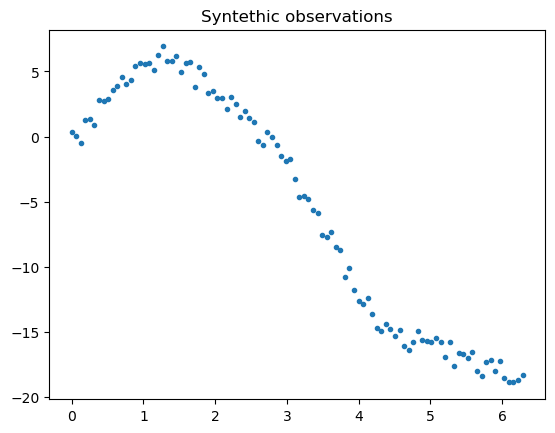

In [3]:
x, y = generate_data(obs_type='harmonic')
plt.plot(x, y, '.')
plt.title("Syntethic observations")
plt.show()

In [6]:
def plot_data(x, y, model, loss_history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    # Left will plot the observations and current prediction
    X = torch.reshape(x, (x.shape[0], 1)).to(device)
    model_y = model(X).cpu().detach().numpy()
    axs[0].plot(x, y, '.')
    axs[0].plot(x, model_y, color='r')
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")
    axs[1].semilogy(range(len(loss_history)), loss_history, color='r')
    axs[1].set_yscale("log")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("MSE")
    plt.show()

In [8]:
@interact(hidden_layers=widgets.IntSlider(min=1, max=20, step=1, value=5,  description='Hidden layers'),
            neurons_per_layer=widgets.IntSlider(min=1, max=100, step=1, value=20, layout=Layout(width='500px'), description='Neurons HLayers'),
            activation_hidden=widgets.Dropdown(options=['relu', 'sigmoid', 'tanh', 'linear'], value='relu', layout=Layout(width='500px'), description='Act. Hidden'),
            epochs=widgets.IntSlider(min=100, max=2000, step=100, value=500, layout=Layout(width='500px'), description='Epochs'),
            activation_output=widgets.Dropdown(options=['relu', 'sigmoid', 'tanh', 'linear'], value='linear', description='Act. Output'),
            batch_norm_str=widgets.Dropdown(options=['With', 'Without'], value='With', description='Batch Norm'))
def NN_TestBed(hidden_layers=1, neurons_per_layer=1, epochs=500, activation_hidden='relu', activation_output='linear', batch_norm_str='With'):
    
    button = widgets.Button(description="Start Training!")
    output = widgets.Output()

    def on_button_click(b):
        with output:
            clear_output(wait=True)
            print("Training...")
            batch_norm = True if batch_norm_str == 'With' else False
            model = DenseModel(hidden_layers, neurons_per_layer, activation_hidden, activation_output, batch_norm).to(device)
            print("Total number of parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

            t = time.time()
            loss_history, trained_model = training(loss=nn.MSELoss(), optimizer=torch.optim.Adam(model.parameters(), lr=0.01),
                                                   model=model, epochs=epochs, x=x, y=y, device=device)

            print(f"Done! Time:{(time.time() - t):0.2f} seg")
            print(f"Last loss: {loss_history[-1]:0.2f}")
            plot_data(x, y, trained_model, loss_history)
            del model
            
    button.on_click(on_button_click)
    display(button)
    display(output)

interactive(children=(IntSlider(value=5, description='Hidden layers', max=20, min=1), IntSlider(value=20, desc…